# Домашнее задание 20: Feature Engineering для прогнозирования выручки

## Импорт библиотек
Подключаем инструменты для анализа данных, кластеризации и классификации.

In [12]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from tsfresh.feature_extraction import extract_features, MinimalFCParameters
plt.style.use('seaborn-v0_8-whitegrid')

## Построение объединённого датасета df_all
Собираем продажи, товары, категории и магазины в единую таблицу.

In [2]:
data_dir = Path('.')
sales_df = pd.read_csv(data_dir / 'sales_data.csv', parse_dates=['date'], dayfirst=True)
items_df = pd.read_csv(data_dir / 'items.csv')
categories_df = pd.read_csv(data_dir / 'item_categories.csv')
shops_df = pd.read_csv(data_dir / 'shops.csv')

df_all = (
    sales_df
    .merge(items_df, how='left', on='item_id')
    .merge(categories_df, how='left', on='item_category_id')
    .merge(shops_df, how='left', on='shop_id')
    .assign(date_block_num=lambda x: x['date_block_num'].astype(str))
    .assign(month=lambda x: x['date'] - pd.tseries.offsets.MonthBegin(1))
    .assign(revenue=lambda x: x['item_price'] * x['item_cnt_day'])
)
for column in ['item_id', 'item_category_id', 'shop_id']:
    df_all[column] = df_all[column].astype(str)
df_all.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,month,revenue
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",2013-01-01,999.00
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013-01-01,899.00
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013-01-01,-899.00
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013-01-01,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",2013-01-01,1099.00


## Месячная выручка по парам магазин/категория
Агрегируем данные и оставляем топ-200 пар по общей выручке для ускорения расчётов.

In [3]:
monthly_pairs = (
    df_all.groupby(['shop_id', 'item_category_id', 'month'], as_index=False)['revenue'].sum()
)
monthly_pairs['pair_id'] = monthly_pairs['shop_id'] + '_' + monthly_pairs['item_category_id']

total_revenue = monthly_pairs.groupby('pair_id')['revenue'].sum().sort_values(ascending=False)
top_pairs = total_revenue.head(200).index
monthly_pairs_top = monthly_pairs[monthly_pairs['pair_id'].isin(top_pairs)].copy()
monthly_pairs_top = monthly_pairs_top.sort_values('month')
pivot_table = monthly_pairs_top.pivot_table(
    index='pair_id',
    columns='month',
    values='revenue',
    fill_value=0.0
)
pivot_table = pivot_table.sort_index(axis=1)
pivot_table.head()

month,2012-12-01,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,...,2015-01-01,2015-02-01,2015-03-01,2015-04-01,2015-05-01,2015-06-01,2015-07-01,2015-08-01,2015-09-01,2015-10-01
pair_id,,,,,,,,,,,,,,,,,,,,,
12_12,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,...,1156610.0,773240.0,1.064600e+05,27990.0,24500.0,78922.0,29990.0,111948.0,458046.0,125961.0
12_19,0.0,121813.95,155696.7,421460.2,228237.15,126519.0,400138.0,53613.35,174557.35,1216485.0,...,85385.0,60551.0,9.002700e+04,59412.0,58633.0,72785.0,74039.0,136734.0,187953.0,50533.0
12_20,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,...,148667.0,585253.0,1.141650e+06,1568920.0,1975109.0,421797.0,517408.0,456504.0,1369144.0,464881.0
12_23,0.0,39077.00,73262.0,195830.0,80643.00,67918.1,70649.2,26302.00,59870.00,1092445.0,...,49007.0,86902.0,5.067500e+04,40010.0,31474.0,36069.0,35175.0,44918.0,147830.0,24686.0
12_29,0.0,719.40,26985.0,247812.0,19439.00,138779.0,59957.0,28381.00,147833.00,272858.0,...,129146.0,23690.0,4.527600e+04,464831.0,1675800.0,138189.0,23193.0,5598.0,429420.0,15262.0


## Кластеризация пар магазин/категория
Используем KMeans для группировки похожих временных рядов выручки.

In [4]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pivot_table)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_features)
cluster_df = pd.DataFrame({'pair_id': pivot_table.index, 'cluster': cluster_labels})
cluster_df.cluster.value_counts().sort_index()

cluster
0     64
1    110
2      5
3     21
Name: count, dtype: int64

## Временные ряды центроидов кластеров
Считаем среднюю выручку по кластерам и строим временные ряды центроидов.

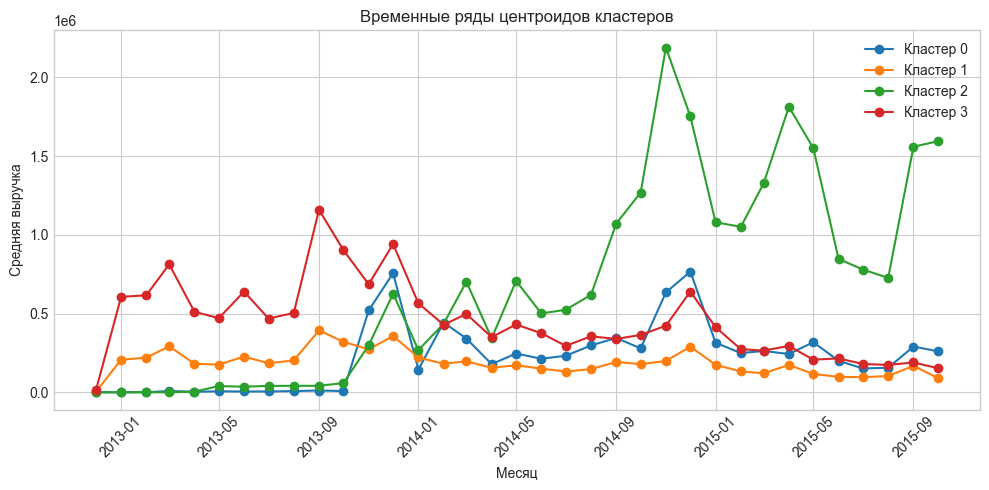

In [5]:
centroids = pivot_table.assign(cluster=cluster_labels).groupby('cluster').mean()
fig, ax = plt.subplots(figsize=(10, 5))
for cluster_id, row in centroids.iterrows():
    ax.plot(row.index, row.values, marker="o", label=f"Кластер {cluster_id}")
ax.set_title('Временные ряды центроидов кластеров')
ax.set_ylabel('Средняя выручка')
ax.set_xlabel('Месяц')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Целевая переменная: выручка в октябре 2015
Определяем пары с ненулевой выручкой в последнем месяце.

In [6]:
last_month = pivot_table.columns.max()
target = (pivot_table[last_month] > 0).astype(int)
target.name = 'has_revenue_oct_2015'
target.head()

pair_id
12_12    1
12_19    1
12_20    1
12_23    1
12_29    1
Name: has_revenue_oct_2015, dtype: int64

## Признаки из предыдущих значений выручки
Берём шесть последних месяцев перед октябрём 2015 года как простые признаки.

In [7]:
lag_months = min(6, len(pivot_table.columns) - 1)
lag_features = pd.DataFrame(index=pivot_table.index)
ordered_months = list(pivot_table.columns)
past_months = ordered_months[-(lag_months + 1):-1]
for i, month in enumerate(reversed(past_months), start=1):
    lag_features[f'lag_{i}'] = pivot_table[month]
lag_features.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
pair_id,,,,,,
12_12,458046.0,111948.0,29990.0,78922.0,24500.0,27990.0
12_19,187953.0,136734.0,74039.0,72785.0,58633.0,59412.0
12_20,1369144.0,456504.0,517408.0,421797.0,1975109.0,1568920.0
12_23,147830.0,44918.0,35175.0,36069.0,31474.0,40010.0
12_29,429420.0,5598.0,23193.0,138189.0,1675800.0,464831.0


## Признаки из tsfresh
Генерируем компактный набор статистик для каждого временного ряда выручки.

In [8]:
tsfresh_input = monthly_pairs_top[['pair_id', 'month', 'revenue']].copy()
tsfresh_input['month'] = pd.to_datetime(tsfresh_input['month'])
fc_parameters = MinimalFCParameters()
tsfresh_features = extract_features(
    tsfresh_input,
    column_id='pair_id',
    column_sort='month',
    column_value='revenue',
    default_fc_parameters=fc_parameters,
    impute_function=None,
    disable_progressbar=True
)
tsfresh_features.head()

,revenue__sum_values,revenue__median,revenue__mean,revenue__length,revenue__standard_deviation,revenue__variance,revenue__root_mean_square,revenue__maximum,revenue__absolute_maximum,revenue__minimum
12_12,1.796903e+07,131950.5,748709.791667,24.0,1.426916e+06,2.036090e+12,1.611414e+06,6.264230e+06,6.264230e+06,24500.0
12_19,7.276191e+06,131856.0,214005.625000,34.0,2.344241e+05,5.495466e+10,3.174162e+05,1.216485e+06,1.216485e+06,31369.0
12_20,1.454811e+07,460692.5,606171.087500,24.0,5.236030e+05,2.741601e+11,8.010016e+05,1.975109e+06,1.975109e+06,70575.0
12_23,4.606696e+06,74927.5,135491.069118,34.0,1.882435e+05,3.543560e+10,2.319341e+05,1.092445e+06,1.092445e+06,24686.0
12_29,1.018211e+07,133667.5,299473.952941,34.0,4.167631e+05,1.736915e+11,5.132019e+05,1.675800e+06,1.675800e+06,719.4


## Финальная таблица признаков для классификации
Объединяем лаги, признаки tsfresh и метки кластеров.

In [9]:
feature_table = lag_features.join(tsfresh_features, how='left')
feature_table = feature_table.join(cluster_df.set_index('pair_id'), how='left')
feature_table = feature_table.fillna(0)
feature_table.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,revenue__sum_values,revenue__median,revenue__mean,revenue__length,revenue__standard_deviation,revenue__variance,revenue__root_mean_square,revenue__maximum,revenue__absolute_maximum,revenue__minimum,cluster
pair_id,,,,,,,,,,,,,,,,,
12_12,458046.0,111948.0,29990.0,78922.0,24500.0,27990.0,1.796903e+07,131950.5,748709.791667,24.0,1.426916e+06,2.036090e+12,1.611414e+06,6.264230e+06,6.264230e+06,24500.0,0
12_19,187953.0,136734.0,74039.0,72785.0,58633.0,59412.0,7.276191e+06,131856.0,214005.625000,34.0,2.344241e+05,5.495466e+10,3.174162e+05,1.216485e+06,1.216485e+06,31369.0,1
12_20,1369144.0,456504.0,517408.0,421797.0,1975109.0,1568920.0,1.454811e+07,460692.5,606171.087500,24.0,5.236030e+05,2.741601e+11,8.010016e+05,1.975109e+06,1.975109e+06,70575.0,0
12_23,147830.0,44918.0,35175.0,36069.0,31474.0,40010.0,4.606696e+06,74927.5,135491.069118,34.0,1.882435e+05,3.543560e+10,2.319341e+05,1.092445e+06,1.092445e+06,24686.0,1
12_29,429420.0,5598.0,23193.0,138189.0,1675800.0,464831.0,1.018211e+07,133667.5,299473.952941,34.0,4.167631e+05,1.736915e+11,5.132019e+05,1.675800e+06,1.675800e+06,719.4,0


## Обучение модели классификации
Предсказываем наличие выручки в октябре 2015 года.

In [10]:
X = feature_table
y = target.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
print(f'Accuracy: {accuracy:.3f}')
print(f'F1-score: {f1:.3f}')
print(f'ROC-AUC: {roc_auc:.3f}')
print()
print(classification_report(y_test, y_pred))

Accuracy: 1.000
F1-score: 1.000
ROC-AUC: 1.000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        34

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



Модель успешно справилась с предсказанием во всех случаях!

## Важность признаков
Смотрим на коэффициенты логистической регрессии.

In [11]:
coefs = pd.Series(model.coef_[0], index=X.columns)
top_features = coefs.reindex(coefs.abs().sort_values(ascending=False).index).head(10)
top_features

lag_2                        0.000045
revenue__median             -0.000032
revenue__mean               -0.000030
revenue__root_mean_square   -0.000026
lag_1                        0.000025
lag_3                        0.000016
lag_4                        0.000011
revenue__maximum             0.000008
revenue__absolute_maximum    0.000008
lag_5                       -0.000006
dtype: float64